In [1]:
from torch.utils.data import Dataset
import os
import cv2
import torch
from torchvision import transforms

import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [2]:
celeba_dir = '/kaggle/input/celebahq-resized-256x256/celeba_hq_256'   

In [3]:
class SketchPhotoDataset(Dataset):
    def __init__(self, image_dir, transform=None, image_size=(256, 256)):
        self.image_dir = image_dir
        self.image_names = os.listdir(image_dir)[:500]
        self.transform = transform
        self.image_size = image_size

        # Separate transform for grayscale sketch if using normalize
        self.gray_transform = transforms.Compose([
            transforms.ToTensor(),                      # [0, 255] → [0, 1]
            transforms.Normalize([0.5], [0.5])          # normalize 1 channel
        ]) if transform else transforms.ToTensor()

    def __len__(self):
        return len(self.image_names)

    def convert_to_sketch(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        inverted = 255 - gray
        blur = cv2.GaussianBlur(inverted, (21, 21), 0)
        inverted_blur = 255 - blur
        sketch = cv2.divide(gray, inverted_blur, scale=256.0)
        return sketch

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = cv2.imread(img_path)

        if image is None:
            raise ValueError(f"Image not found: {img_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.image_size)

        sketch = self.convert_to_sketch(image)
        sketch = cv2.resize(sketch, self.image_size)  # Ensure same size

        if self.transform:
            image = self.transform(image)                      # 3-channel RGB
        else:
            image = transforms.ToTensor()(image)

        sketch = self.gray_transform(sketch)                   # 1-channel

        return sketch, image

In [4]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1] for GANs
])

dataset = SketchPhotoDataset(celeba_dir, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

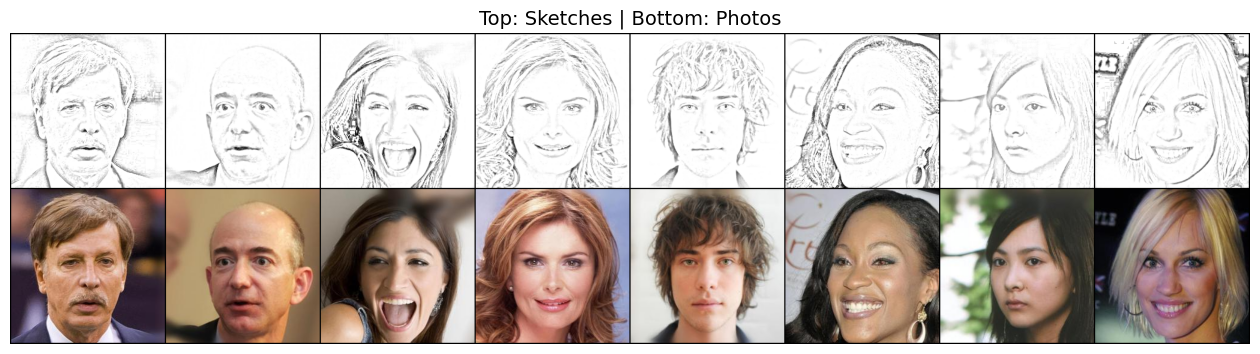

In [5]:
# Get a batch
sketches, photos = next(iter(loader))
sketches, photos = sketches[:8], photos[:8]  # Select first 8 pairs

# Denormalize
def denormalize(tensor):
    return tensor * 0.5 + 0.5

sketches = denormalize(sketches)  # (8, 1, H, W)
photos = denormalize(photos)      # (8, 3, H, W)

# Convert 1-channel sketches to 3-channel for visualization only
sketches_rgb = sketches.repeat(1, 3, 1, 1)  # (8, 3, H, W)

# Stack them as [sk1, sk2, ..., sk8, img1, img2, ..., img8]
grid = torch.cat([sketches_rgb, photos], dim=0)  # (16, 3, H, W)
grid = vutils.make_grid(grid, nrow=8, padding=2)

# Plot
plt.figure(figsize=(16, 5))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.title("Top: Sketches | Bottom: Photos", fontsize=14)
plt.axis('off')
plt.show()


In [6]:
sketches.shape

torch.Size([8, 1, 256, 256])

In [7]:
import torch
import torch.nn as nn

class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_dropout=False):
        super().__init__()
        if down:
            self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.block(x)
        return self.dropout(x) if self.use_dropout else x


class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super().__init__()
        # Encoder
        self.down1 = UNetBlock(in_channels, 64, down=True, use_dropout=False)
        self.down2 = UNetBlock(64, 128)
        self.down3 = UNetBlock(128, 256)
        self.down4 = UNetBlock(256, 512)
        self.down5 = UNetBlock(512, 512)
        self.down6 = UNetBlock(512, 512)
        self.down7 = UNetBlock(512, 512)
        self.down8 = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU()
        )

        # Decoder
        self.up1 = UNetBlock(512, 512, down=False, use_dropout=True)
        self.up2 = UNetBlock(1024, 512, down=False, use_dropout=True)
        self.up3 = UNetBlock(1024, 512, down=False, use_dropout=True)
        self.up4 = UNetBlock(1024, 512, down=False)
        self.up5 = UNetBlock(1024, 256, down=False)
        self.up6 = UNetBlock(512, 128, down=False)
        self.up7 = UNetBlock(256, 64, down=False)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        bottleneck = self.down8(d7)

        # Decoder with skip connections
        u1 = self.up1(bottleneck)
        u2 = self.up2(torch.cat([u1, d7], dim=1))
        u3 = self.up3(torch.cat([u2, d6], dim=1))
        u4 = self.up4(torch.cat([u3, d5], dim=1))
        u5 = self.up5(torch.cat([u4, d4], dim=1))
        u6 = self.up6(torch.cat([u5, d3], dim=1))
        u7 = self.up7(torch.cat([u6, d2], dim=1))
        out = self.final(torch.cat([u7, d1], dim=1))
        return out
    

In [8]:
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=4):
        super().__init__()
        def block(in_c, out_c, stride=2):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 4, stride, 1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.2, inplace=True)
            )

        self.model = nn.Sequential(
            block(in_channels, 64),
            block(64, 128),
            block(128, 256),
            block(256, 512, stride=1),
            nn.Conv2d(512, 1, 4, 1, 1)  # Output: Patch matrix
        )

    def forward(self, x, y):
        # Concatenate sketch and photo: (B, 1+3, H, W)
        input = torch.cat([x, y], dim=1)
        return self.model(input)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

# Hyperparameters
EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 2e-4
LAMBDA_L1 = 100
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SAVE_SAMPLE_EVERY = 10


In [10]:
G = UNetGenerator().to(DEVICE)
D = PatchDiscriminator().to(DEVICE)

bce_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

optimizer_G = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))


Epoch [1/100]  D Loss: 0.3062  G Loss: 35.6198
Epoch [2/100]  D Loss: 0.5285  G Loss: 34.8975
Epoch [3/100]  D Loss: 0.3394  G Loss: 33.2984
Epoch [4/100]  D Loss: 0.2868  G Loss: 26.3504
Epoch [5/100]  D Loss: 0.5174  G Loss: 26.4759
Epoch [6/100]  D Loss: 0.7391  G Loss: 30.2568
Epoch [7/100]  D Loss: 0.1282  G Loss: 26.3824
Epoch [8/100]  D Loss: 0.1030  G Loss: 29.3433
Epoch [9/100]  D Loss: 0.1801  G Loss: 20.8178
Epoch [10/100]  D Loss: 0.3602  G Loss: 19.2959


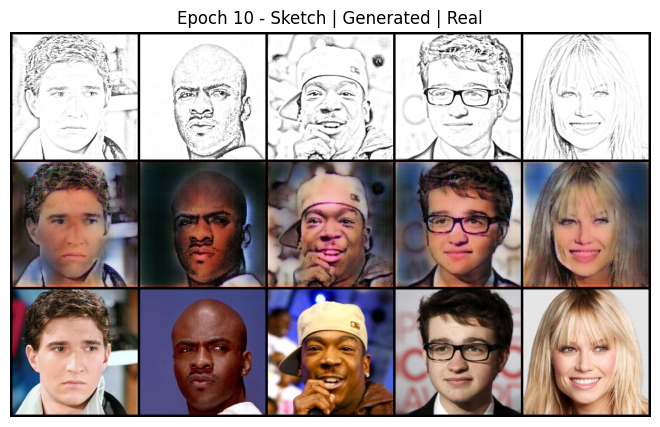

Epoch [11/100]  D Loss: 0.8063  G Loss: 34.1288
Epoch [12/100]  D Loss: 0.1258  G Loss: 23.4349
Epoch [13/100]  D Loss: 0.5044  G Loss: 20.7321
Epoch [14/100]  D Loss: 0.2146  G Loss: 20.5543
Epoch [15/100]  D Loss: 0.6854  G Loss: 22.5206
Epoch [16/100]  D Loss: 0.0191  G Loss: 22.1650
Epoch [17/100]  D Loss: 0.0487  G Loss: 26.4357
Epoch [18/100]  D Loss: 0.0657  G Loss: 23.1263
Epoch [19/100]  D Loss: 0.0132  G Loss: 20.6711
Epoch [20/100]  D Loss: 0.0237  G Loss: 20.8427


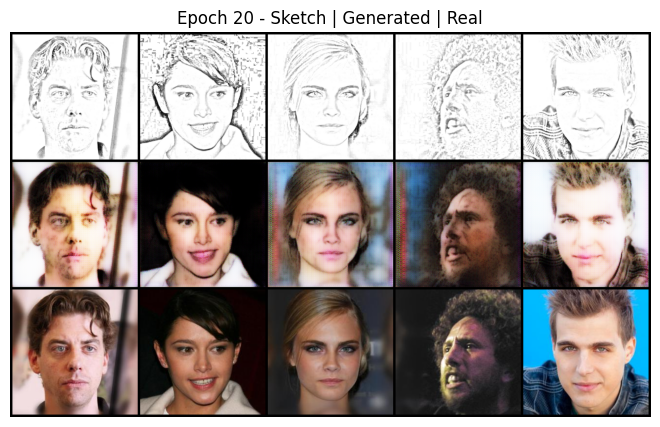

Epoch [21/100]  D Loss: 0.0102  G Loss: 31.9079
Epoch [22/100]  D Loss: 0.0148  G Loss: 23.4279
Epoch [23/100]  D Loss: 0.6935  G Loss: 15.4804
Epoch [24/100]  D Loss: 0.6267  G Loss: 14.1054
Epoch [25/100]  D Loss: 0.7044  G Loss: 13.6801
Epoch [26/100]  D Loss: 0.5588  G Loss: 17.4979
Epoch [27/100]  D Loss: 0.5551  G Loss: 16.4926
Epoch [28/100]  D Loss: 0.2900  G Loss: 18.4565
Epoch [29/100]  D Loss: 0.8052  G Loss: 19.8872
Epoch [30/100]  D Loss: 0.3549  G Loss: 13.4168


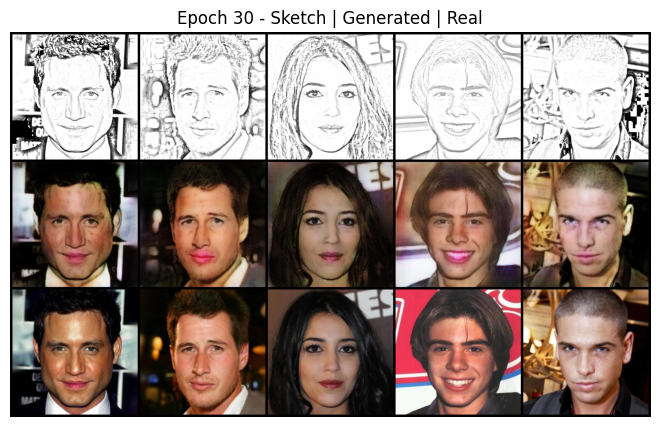

Epoch [31/100]  D Loss: 0.3486  G Loss: 17.3183
Epoch [32/100]  D Loss: 0.3499  G Loss: 21.2414
Epoch [33/100]  D Loss: 0.3455  G Loss: 14.8106
Epoch [34/100]  D Loss: 0.0472  G Loss: 16.7346
Epoch [35/100]  D Loss: 0.0126  G Loss: 17.3163
Epoch [36/100]  D Loss: 0.0390  G Loss: 17.6053
Epoch [37/100]  D Loss: 1.8569  G Loss: 16.8583
Epoch [38/100]  D Loss: 0.8474  G Loss: 12.2098
Epoch [39/100]  D Loss: 0.1846  G Loss: 12.6531
Epoch [40/100]  D Loss: 0.0657  G Loss: 14.5567


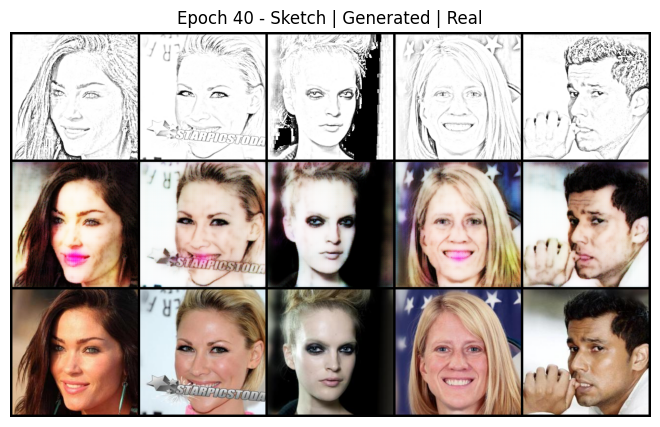

Epoch [41/100]  D Loss: 0.0557  G Loss: 18.6633
Epoch [42/100]  D Loss: 0.0333  G Loss: 15.6877
Epoch [43/100]  D Loss: 0.0126  G Loss: 22.1473
Epoch [44/100]  D Loss: 0.0235  G Loss: 20.6032
Epoch [45/100]  D Loss: 0.0092  G Loss: 18.0308
Epoch [46/100]  D Loss: 0.1397  G Loss: 11.7773
Epoch [47/100]  D Loss: 1.1624  G Loss: 19.9617
Epoch [48/100]  D Loss: 0.0164  G Loss: 16.1842
Epoch [49/100]  D Loss: 0.6341  G Loss: 9.8762
Epoch [50/100]  D Loss: 0.9013  G Loss: 12.6259


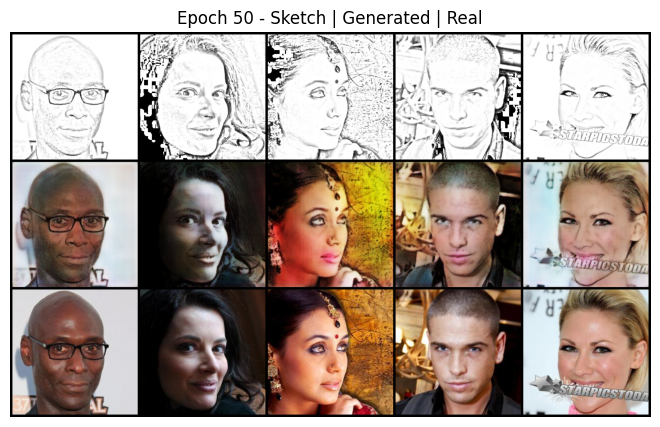

Epoch [51/100]  D Loss: 0.2866  G Loss: 13.4453
Epoch [52/100]  D Loss: 0.0858  G Loss: 23.5778
Epoch [53/100]  D Loss: 0.0262  G Loss: 16.5454
Epoch [54/100]  D Loss: 0.0029  G Loss: 14.8733
Epoch [55/100]  D Loss: 0.0299  G Loss: 25.8978
Epoch [56/100]  D Loss: 0.0073  G Loss: 15.5484
Epoch [57/100]  D Loss: 0.0110  G Loss: 21.2168
Epoch [58/100]  D Loss: 0.0057  G Loss: 19.7671
Epoch [59/100]  D Loss: 0.0031  G Loss: 18.4607
Epoch [60/100]  D Loss: 0.0071  G Loss: 20.7742


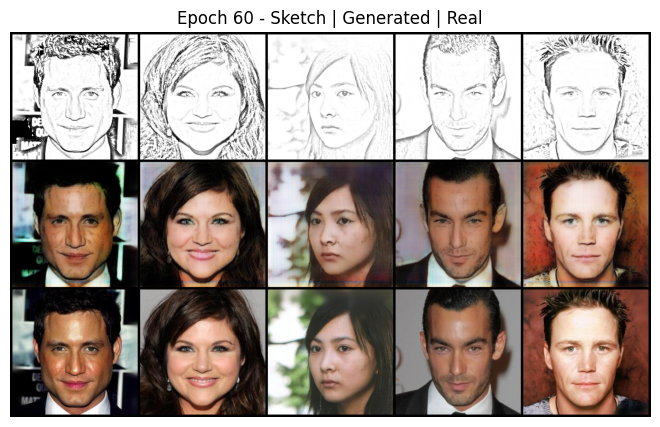

Epoch [61/100]  D Loss: 0.0183  G Loss: 26.1562
Epoch [62/100]  D Loss: 0.0292  G Loss: 13.9024
Epoch [63/100]  D Loss: 0.0038  G Loss: 17.3891
Epoch [64/100]  D Loss: 0.0049  G Loss: 19.1791
Epoch [65/100]  D Loss: 0.0038  G Loss: 26.3033
Epoch [66/100]  D Loss: 1.2840  G Loss: 23.7854
Epoch [67/100]  D Loss: 0.7000  G Loss: 11.6526
Epoch [68/100]  D Loss: 0.7647  G Loss: 16.4652
Epoch [69/100]  D Loss: 0.5803  G Loss: 19.2975
Epoch [70/100]  D Loss: 0.5087  G Loss: 13.4118


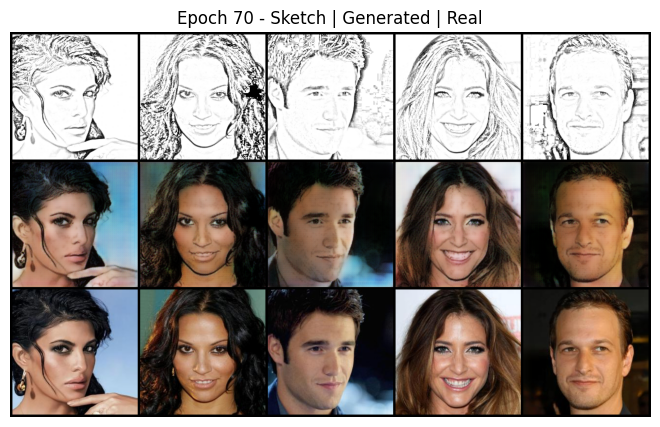

Epoch [71/100]  D Loss: 0.1216  G Loss: 12.8556
Epoch [72/100]  D Loss: 0.2751  G Loss: 11.9200
Epoch [73/100]  D Loss: 0.1109  G Loss: 13.9332
Epoch [74/100]  D Loss: 0.1720  G Loss: 19.2422
Epoch [75/100]  D Loss: 0.1999  G Loss: 11.8396
Epoch [76/100]  D Loss: 0.0166  G Loss: 13.3900
Epoch [77/100]  D Loss: 0.0090  G Loss: 15.0816
Epoch [78/100]  D Loss: 0.0376  G Loss: 14.9462
Epoch [79/100]  D Loss: 0.0419  G Loss: 16.8591
Epoch [80/100]  D Loss: 0.0064  G Loss: 19.1284


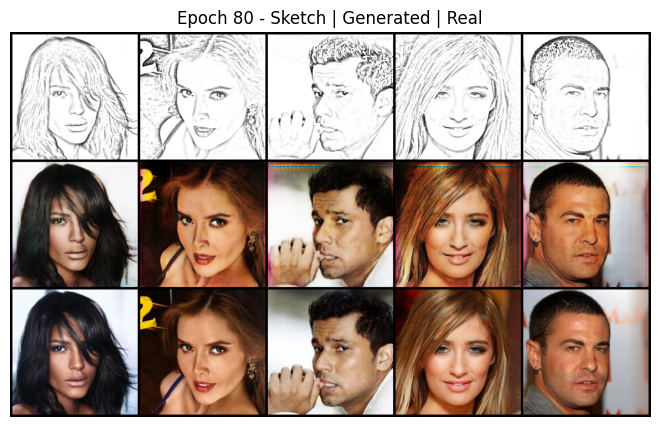

Epoch [81/100]  D Loss: 0.0021  G Loss: 29.6219
Epoch [82/100]  D Loss: 0.7156  G Loss: 9.8534
Epoch [83/100]  D Loss: 0.4042  G Loss: 13.7001
Epoch [84/100]  D Loss: 0.2525  G Loss: 15.1663
Epoch [85/100]  D Loss: 1.4584  G Loss: 24.3647
Epoch [86/100]  D Loss: 0.0386  G Loss: 14.3322
Epoch [87/100]  D Loss: 0.0044  G Loss: 13.4585
Epoch [88/100]  D Loss: 0.0174  G Loss: 14.6607
Epoch [89/100]  D Loss: 0.0076  G Loss: 13.3343
Epoch [90/100]  D Loss: 0.0228  G Loss: 16.6834


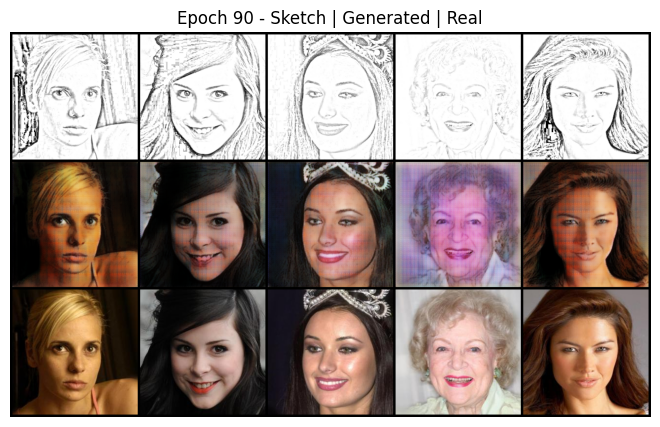

Epoch [91/100]  D Loss: 0.0019  G Loss: 16.8445
Epoch [92/100]  D Loss: 0.0071  G Loss: 19.7360
Epoch [93/100]  D Loss: 0.0070  G Loss: 19.2972
Epoch [94/100]  D Loss: 0.0041  G Loss: 14.9158
Epoch [95/100]  D Loss: 0.0035  G Loss: 16.7376
Epoch [96/100]  D Loss: 0.1536  G Loss: 31.0168
Epoch [97/100]  D Loss: 0.6512  G Loss: 9.7026
Epoch [98/100]  D Loss: 0.9722  G Loss: 9.9785
Epoch [99/100]  D Loss: 0.6716  G Loss: 8.9227
Epoch [100/100]  D Loss: 0.4042  G Loss: 8.3289


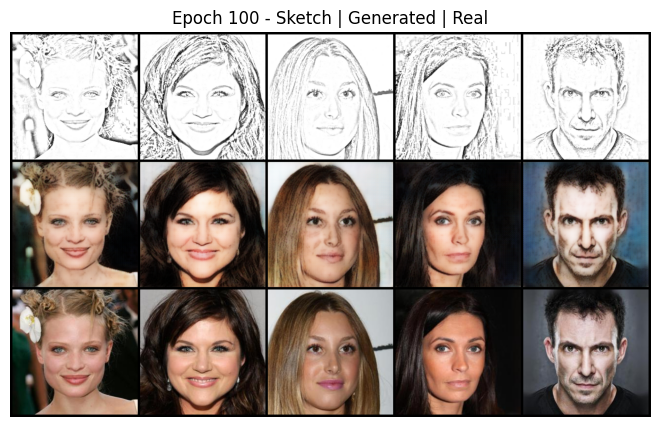

In [11]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import os

def denormalize(tensor):
    return tensor * 0.5 + 0.5

def save_sample(sketches, real_images, fake_images, epoch):
    sketches = denormalize(sketches).repeat(1, 3, 1, 1)  # make sketches 3-channel
    real_images = denormalize(real_images)
    fake_images = denormalize(fake_images)

    # Interleave them: sketch, fake, real
    combined = torch.cat([sketches, fake_images, real_images], dim=0)
    grid = vutils.make_grid(combined, nrow=5, padding=5)

    plt.figure(figsize=(15, 5))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(f"Epoch {epoch} - Sketch | Generated | Real")
    plt.axis('off')
    plt.show()


for epoch in range(1, EPOCHS + 1):
    G.train()
    D.train()
    for batch in loader:
        sketches, real_images = batch
        sketches = sketches.to(DEVICE)
        real_images = real_images.to(DEVICE)

        #######################
        # Train Discriminator #
        #######################
        fake_images = G(sketches)

        D_real = D(sketches, real_images)
        D_fake = D(sketches, fake_images.detach())

        real_labels = torch.ones_like(D_real)
        fake_labels = torch.zeros_like(D_fake)

        D_loss_real = bce_loss(D_real, real_labels)
        D_loss_fake = bce_loss(D_fake, fake_labels)
        D_loss = (D_loss_real + D_loss_fake) * 0.5

        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()

        ##################
        # Train Generator#
        ##################
        D_output_fake = D(sketches, fake_images)
        G_adv_loss = bce_loss(D_output_fake, real_labels)
        G_l1_loss = l1_loss(fake_images, real_images)
        G_loss = G_adv_loss + LAMBDA_L1 * G_l1_loss

        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch}/{EPOCHS}]  D Loss: {D_loss.item():.4f}  G Loss: {G_loss.item():.4f}")

    # Save sample outputs
    if epoch % SAVE_SAMPLE_EVERY == 0:
        G.eval()
        with torch.no_grad():
            sketches, real_images = next(iter(loader))
            sketches = sketches[:5].to(DEVICE)
            real_images = real_images[:5].to(DEVICE)
            fake_images = G(sketches)
            save_sample(sketches, real_images, fake_images, epoch)


In [12]:
# Save Generator model
torch.save(G.state_dict(), "pix2pix_generator.pth")

In [15]:
# Get a single batch from the loader
sketches, real_images = next(iter(loader))

# Select one sample
sketch = sketches[0]           # Shape: (1, H, W)
real_image = real_images[0]    # Optional: For comparison


G = UNetGenerator().to(DEVICE)
G.load_state_dict(torch.load("pix2pix_generator.pth",weights_only=True))
G.eval()

with torch.no_grad():
    sketch_input = sketch.unsqueeze(0).to(DEVICE)  # Add batch dimension → (1, 1, H, W)
    fake_image = G(sketch_input)    

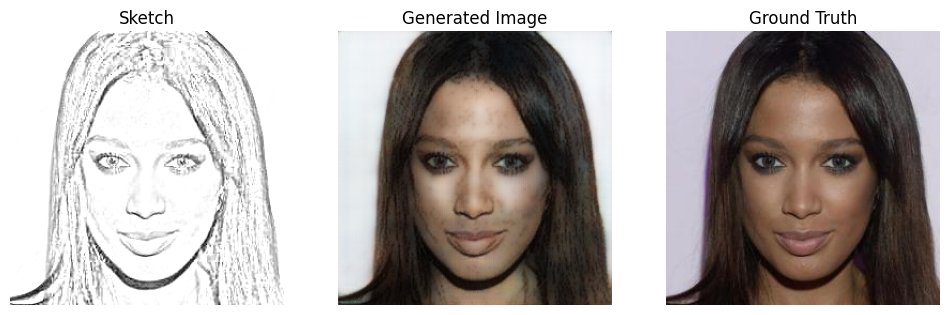

In [16]:
def denormalize(t):
    return t * 0.5 + 0.5

import matplotlib.pyplot as plt

sketch_np = denormalize(sketch).squeeze().cpu().numpy()
fake_np = denormalize(fake_image.squeeze()).permute(1, 2, 0).cpu().numpy()
real_np = denormalize(real_image).permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Sketch")
plt.imshow(sketch_np, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Generated Image")
plt.imshow(fake_np)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Ground Truth")
plt.imshow(real_np)
plt.axis('off')

plt.show()
